In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import pickle
import time
from sklearn.impute import SimpleImputer

In [2]:
np.random.seed(42) 

In [3]:
claims_data = pd.read_csv('ProcessedClaimDataLog.csv')

In [4]:
def identify_columns(claims_data):

    # Identify categorical and numerical columns
    categorical_cols = claims_data.select_dtypes(include=['object', 'string']).columns.tolist()
    numerical_cols = claims_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Remove the target variable from the feature lists
    log_transform = True
    target_col = 'LogSettlementValue'

    # Remove both the log-transformed target AND the original settlement value from features
    if target_col in numerical_cols:
        numerical_cols.remove(target_col)
    if 'SettlementValue' in numerical_cols: 
        numerical_cols.remove('SettlementValue') 

    print(f"\nCategorical columns: {categorical_cols}")
    print(f"Numerical columns: {numerical_cols}")
    print(f"Target column: {target_col}")

    return categorical_cols, numerical_cols, target_col


In [5]:
if 'AccidentDate' in claims_data.columns and 'ClaimDate' in claims_data.columns:
    claims_data['DaysBetweenAccidentAndClaim'] = claims_data['ClaimDate'] - claims_data['AccidentDate']


In [6]:
categorical_cols, numerical_cols, target_col = identify_columns(claims_data=claims_data)


Categorical columns: ['AccidentType', 'DominantInjury', 'VehicleType', 'WeatherConditions', 'AccidentDescription', 'InjuryDescription', 'Gender']
Numerical columns: ['InjuryPrognosis', 'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'ExceptionalCircumstances', 'MinorPsychologicalInjury', 'Whiplash', 'AccidentDate', 'ClaimDate', 'VehicleAge', 'DriverAge', 'NumberOfPassengers', 'PoliceReportFiled', 'WitnessPresent', 'DaysBetweenAccidentAndClaim']
Target column: LogSettlementValue


In [7]:
X = claims_data.drop(columns=[target_col])
y = claims_data[target_col]

In [8]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: 75% train, 25% validation (from the train+validation set)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [9]:
print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 2577 samples
Validation set size: 860 samples
Test set size: 860 samples


In [10]:
# Update categorical and numerical columns based on the transformed dataset
def define_preprocessor(X_train):
    categorical_cols, numerical_cols, _ = identify_columns(claims_data=claims_data)

    categorical_cols = [col for col in categorical_cols if col in X_train.columns]
    numerical_cols = [col for col in numerical_cols if col in X_train.columns]

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
    ])

    return preprocessor

In [11]:
# Define a list of models to try
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Random Forest': RandomForestRegressor(random_state=42),
}

In [12]:
# Function to evaluate a model
def evaluate_model(model, X, y, model_name):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R^2': r2,
        'Name': model_name
    }


In [18]:
preprocessor = define_preprocessor(claims_data)


Categorical columns: ['AccidentType', 'DominantInjury', 'VehicleType', 'WeatherConditions', 'AccidentDescription', 'InjuryDescription', 'Gender']
Numerical columns: ['InjuryPrognosis', 'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'ExceptionalCircumstances', 'MinorPsychologicalInjury', 'Whiplash', 'AccidentDate', 'ClaimDate', 'VehicleAge', 'DriverAge', 'NumberOfPassengers', 'PoliceReportFiled', 'WitnessPresent', 'DaysBetweenAccidentAndClaim']
Target column: LogSettlementValue


In [19]:
# Dictionary to store model results

model_results = {}
print("\nTraining and evaluating models:")
for name, model in models.items():
    start_time = time.time()
    
    # Create pipeline with preprocessing and model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train the model
    print(f"Training {name}...")
    pipeline.fit(X_train, y_train)
    
    # Evaluate on validation set
    results = evaluate_model(pipeline, X_val, y_val, name)
    results['Training Time'] = time.time() - start_time
    model_results[name] = results
    
    print(f"  {name} - RMSE: {results['RMSE']:.2f}, R^2: {results['R^2']:.4f}, Time: {results['Training Time']:.2f}s")
    
    # Store the pipeline
    model_results[name]['pipeline'] = pipeline



Training and evaluating models:
Training Linear Regression...
  Linear Regression - RMSE: 0.37, R^2: 0.6863, Time: 0.11s
Training Ridge Regression...
  Ridge Regression - RMSE: 0.37, R^2: 0.6867, Time: 0.05s
Training Random Forest...
  Random Forest - RMSE: 0.20, R^2: 0.9044, Time: 3.54s


In [20]:
# using RSMe to compare the models
best_model_name = min(model_results, key=lambda k: model_results[k]['RMSE'])
print(f"\nBest model based on validation RMSE: {best_model_name}")
best_pipeline = model_results[best_model_name]['pipeline']

# Tuning the best hyperparameter Tuning for the Best Model
param_grid = {}

if best_model_name == 'Linear Regression':
    # regression model does not have hyperparameters to tune but best to keep this to keep track 
    pass
elif best_model_name == 'Ridge Regression':
    param_grid = {
        'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
    }


Best model based on validation RMSE: Random Forest


In [21]:
# only performs hyperparameter tuning if we have parameters to tune
if param_grid:
    print(f"\nPerforming hyperparameter tuning for {best_model_name}...")
    
# cross validation 
    grid_search = GridSearchCV(
        best_pipeline,
        param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    best_pipeline = grid_search.best_estimator_
    
    tuned_results = evaluate_model(best_pipeline, X_val, y_val, f"{best_model_name} (Tuned)")
    print(f"Tuned model - RMSE: {tuned_results['RMSE']:.2f}, R^2: {tuned_results['R^2']:.4f}")
    
    model_results[f"{best_model_name} (Tuned)"] = tuned_results
    model_results[f"{best_model_name} (Tuned)"]['pipeline'] = best_pipeline
    
    if tuned_results['RMSE'] < model_results[best_model_name]['RMSE']:
        best_model_name = f"{best_model_name} (Tuned)"


Performing hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


Best parameters: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Tuned model - RMSE: 0.20, R^2: 0.9049


In [22]:
# Evaluate the best model on the test set
best_pipeline = model_results[best_model_name]['pipeline']
test_results = evaluate_model(best_pipeline, X_test, y_test, best_model_name)
print(f"\nTest set evaluation for {best_model_name}:")
print(f"  RMSE: {test_results['RMSE']:.2f}")
print(f"  MAE: {test_results['MAE']:.2f}")
print(f"  R^2: {test_results['R^2']:.4f}")


Test set evaluation for Random Forest (Tuned):
  RMSE: 0.18
  MAE: 0.10
  R^2: 0.9225


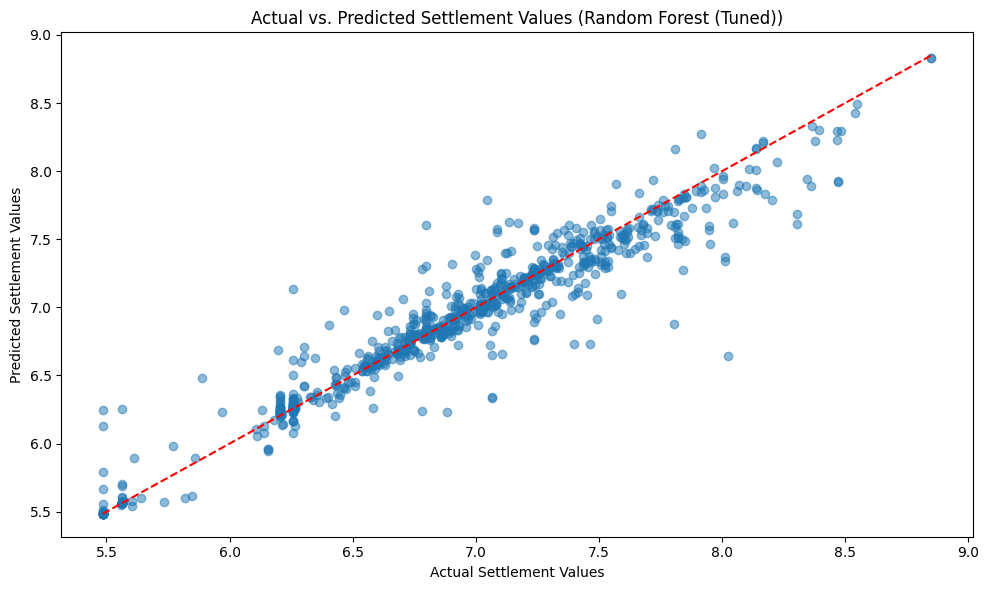

In [23]:
y_pred_test = best_pipeline.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Settlement Values')
plt.ylabel('Predicted Settlement Values')
plt.title(f'Actual vs. Predicted Settlement Values ({best_model_name})')
plt.tight_layout()
plt.show()

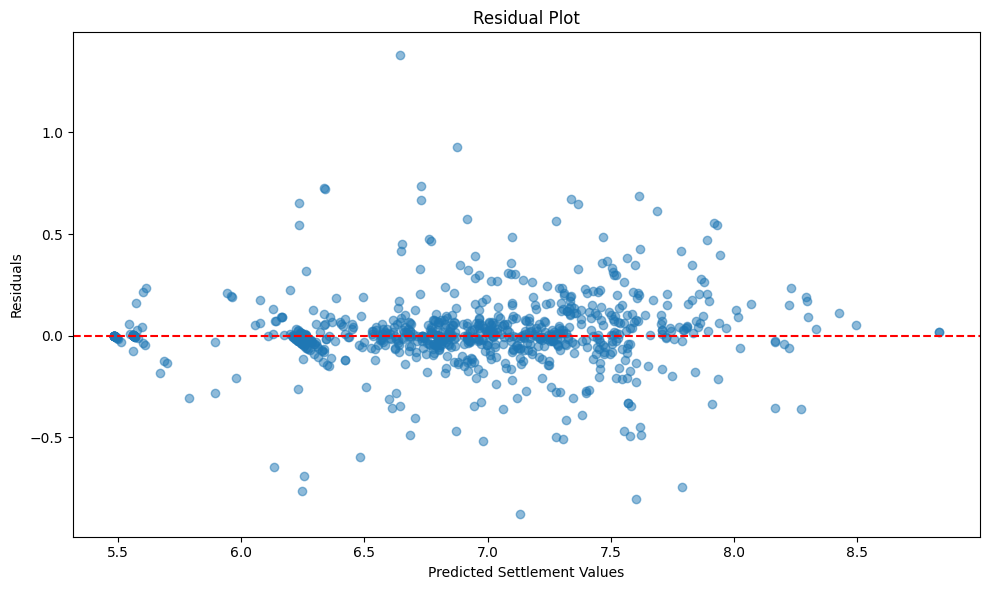

In [24]:
# Calculate residuals
residuals = y_test - y_pred_test

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Settlement Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

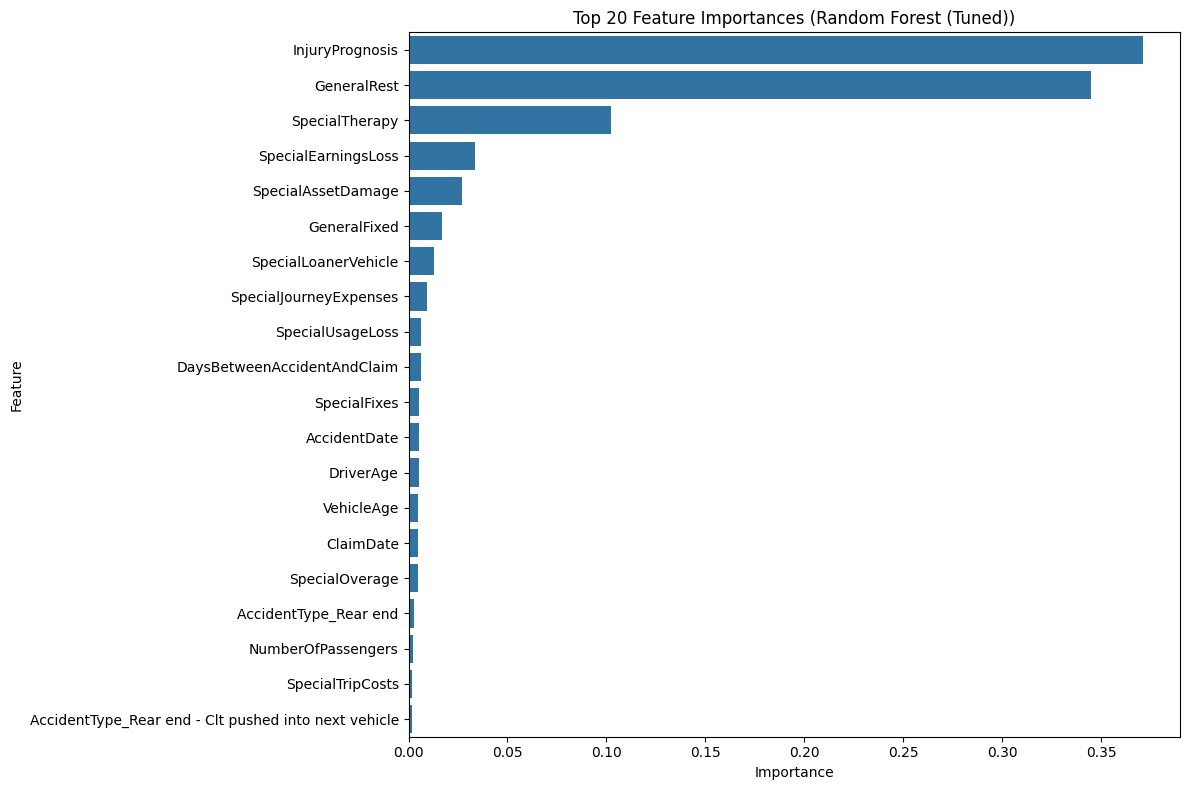


Top 10 important features:
                        Feature  Importance
0               InjuryPrognosis    0.371220
4                   GeneralRest    0.344689
17               SpecialTherapy    0.102126
6           SpecialEarningsLoss    0.033442
9            SpecialAssetDamage    0.027067
12                 GeneralFixed    0.016983
14         SpecialLoanerVehicle    0.012650
16       SpecialJourneyExpenses    0.009560
7              SpecialUsageLoss    0.006320
28  DaysBetweenAccidentAndClaim    0.006116


In [25]:

# Get feature names after preprocessing
if categorical_cols:
    # Get feature names from the preprocessor
    preprocessor = best_pipeline.named_steps['preprocessor']
    feature_names = []
    
    # Get numerical feature names
    if numerical_cols:
        feature_names.extend(numerical_cols)
    
    # Get one-hot encoded feature names
    if categorical_cols:
        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        # Get category names from one-hot encoder
        cat_features = ohe.get_feature_names_out(categorical_cols)
        feature_names.extend(cat_features)
else:
    feature_names = numerical_cols

# For tree-based models, we can get feature importance directly
if hasattr(best_pipeline.named_steps['model'], 'feature_importances_'):
    importances = best_pipeline.named_steps['model'].feature_importances_
    feature_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
    plt.title(f'Top 20 Feature Importances ({best_model_name})')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 important features:")
    print(feature_imp.head(10))
else:
    # For linear models, use coefficients
    if hasattr(best_pipeline.named_steps['model'], 'coef_'):
        coefs = best_pipeline.named_steps['model'].coef_
        
        if coefs.ndim == 1:  # For models with a 1D coefficient array
            feature_imp = pd.DataFrame({
                'Feature': feature_names,
                'Coefficient': coefs
            }).sort_values('Coefficient', key=abs, ascending=False)
            
            # Plot coefficient values
            plt.figure(figsize=(12, 8))
            sns.barplot(x='Coefficient', y='Feature', data=feature_imp.head(20))
            plt.title(f'Top 20 Feature Coefficients ({best_model_name})')
            plt.tight_layout()
            plt.show()
            
            print("\nTop 10 features by coefficient magnitude:")
            print(feature_imp.head(10))
    else:
        # Permutation importance for models without built-in feature importance
        print("\nCalculating permutation importance...")
        perm_importance = permutation_importance(
            best_pipeline, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1
        )
        
        feature_imp = pd.DataFrame({
            'Feature': feature_names,
            'Importance': perm_importance.importances_mean
        }).sort_values('Importance', ascending=False)
        


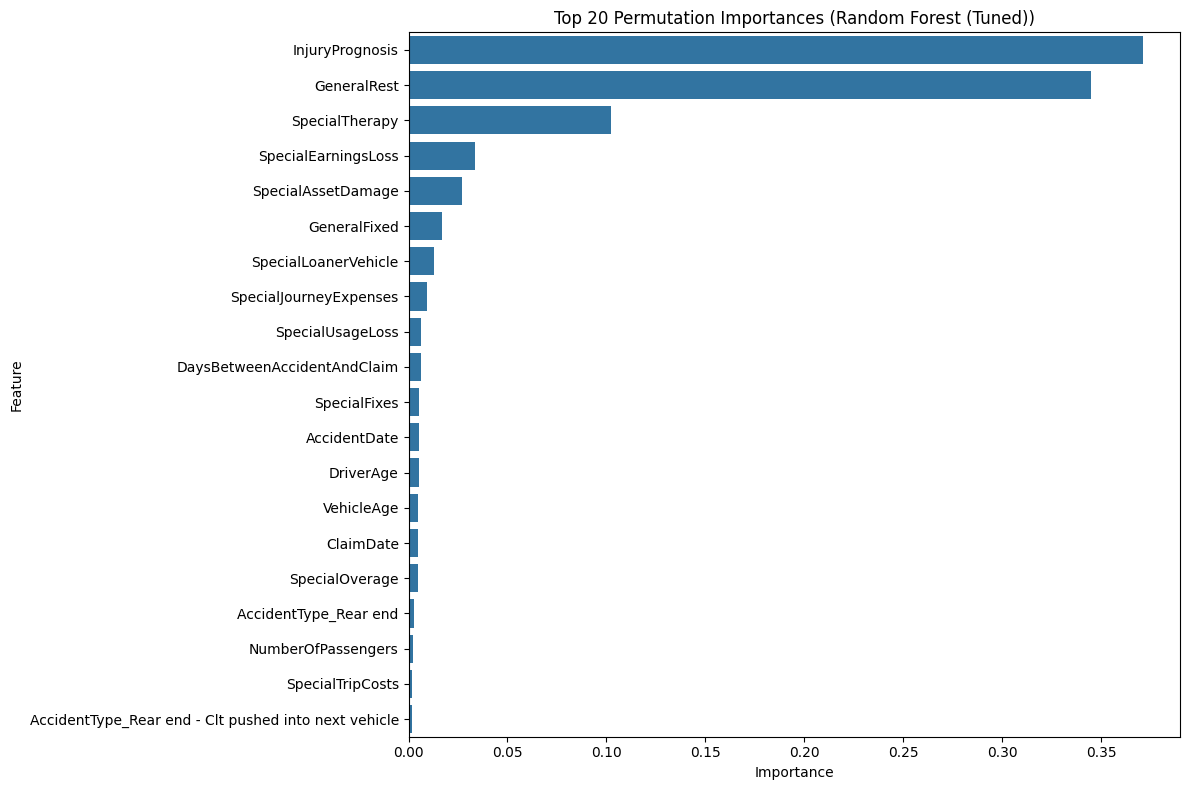


Top 10 features by permutation importance:
                        Feature  Importance
0               InjuryPrognosis    0.371220
4                   GeneralRest    0.344689
17               SpecialTherapy    0.102126
6           SpecialEarningsLoss    0.033442
9            SpecialAssetDamage    0.027067
12                 GeneralFixed    0.016983
14         SpecialLoanerVehicle    0.012650
16       SpecialJourneyExpenses    0.009560
7              SpecialUsageLoss    0.006320
28  DaysBetweenAccidentAndClaim    0.006116


In [26]:
# Plot permutation importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
plt.title(f'Top 20 Permutation Importances ({best_model_name})')
plt.tight_layout()
plt.show()

print("\nTop 10 features by permutation importance:")
print(feature_imp.head(10))

In [27]:
# Check for biases in predictions by protected characteristics
if 'Gender' in X_test.columns:
    # Add predictions to test data
    X_test_with_preds = X_test.copy()
    X_test_with_preds['Predicted'] = y_pred_test
    X_test_with_preds['Actual'] = y_test.values
    X_test_with_preds['Error'] = abs(y_test.values - y_pred_test)
    
    # Calculate average error by gender
    gender_errors = X_test_with_preds.groupby('Gender')['Error'].mean()
    
    print("\nAverage prediction error by gender:")
    print(gender_errors)
    




Average prediction error by gender:
Gender
Female    0.103358
Male      0.103895
Other     0.098060
Name: Error, dtype: float64


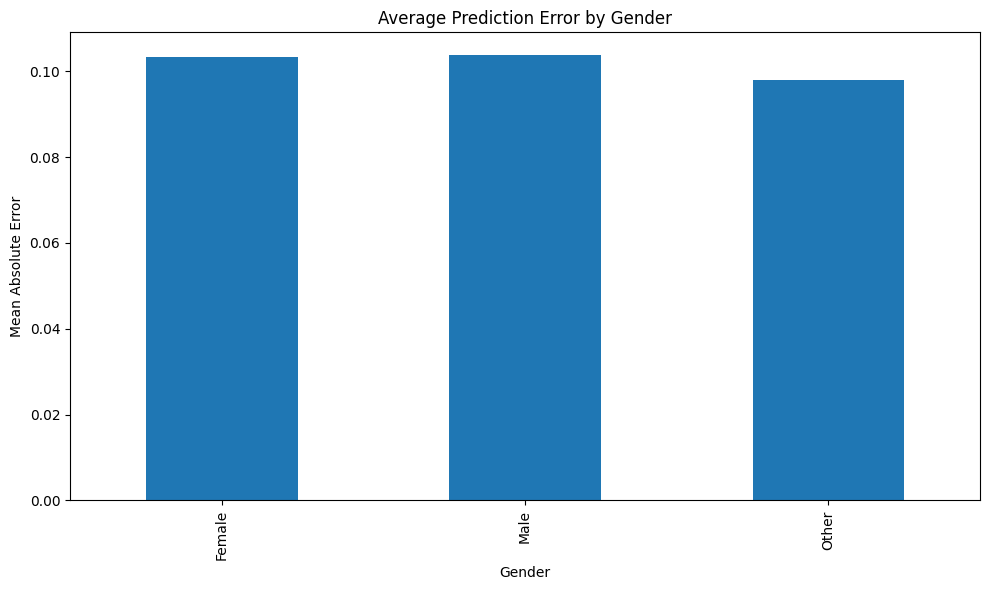

In [28]:
# Plot gender error comparison
plt.figure(figsize=(10, 6))
gender_errors.plot(kind='bar')
plt.title('Average Prediction Error by Gender')
plt.ylabel('Mean Absolute Error')
plt.tight_layout()
plt.show()


In [29]:
# Check for biases by age
if 'DriverAge' in X_test.columns:
    # Create age groups
    X_test_with_preds = X_test.copy()
    X_test_with_preds['Predicted'] = y_pred_test
    X_test_with_preds['Actual'] = y_test.values
    X_test_with_preds['Error'] = abs(y_test.values - y_pred_test)
    X_test_with_preds['AgeGroup'] = pd.cut(X_test_with_preds['DriverAge'], 
                                         bins=[0, 30, 40, 50, 60, 70, 80],
                                         labels=['Under 30', '30-40', '40-50', '50-60', '60-70', '70-80'])
    
    # Calculate average error by age group
    age_group_errors = X_test_with_preds.groupby('AgeGroup')['Error'].mean()

/var/folders/yg/dgf_b89x3dg32kw6l3brl3dm0000gn/T/ipykernel_8052/1506820219.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_errors = X_test_with_preds.groupby('AgeGroup')['Error'].mean()



Average prediction error by age group:
AgeGroup
Under 30    0.117127
30-40       0.099277
40-50       0.081275
50-60       0.094624
60-70       0.114105
70-80       0.099423
Name: Error, dtype: float64


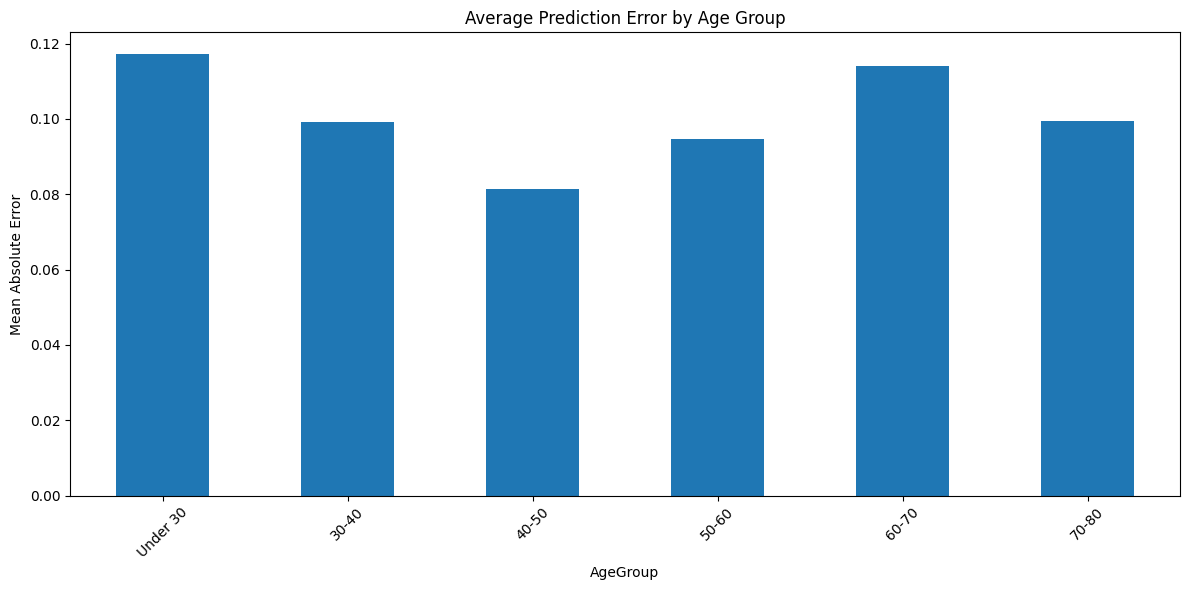

In [30]:
print("\nAverage prediction error by age group:")
print(age_group_errors)

# Plot age group error comparison
plt.figure(figsize=(12, 6))
age_group_errors.plot(kind='bar')
plt.title('Average Prediction Error by Age Group')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [31]:
top_10 = list(feature_imp.head(10)['Feature'])

X_train_filtered = X_train[top_10]

preprocessor = define_preprocessor(X_train_filtered)

rf = RandomForestRegressor(random_state=42)

pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', rf)
    ])


Categorical columns: ['AccidentType', 'DominantInjury', 'VehicleType', 'WeatherConditions', 'AccidentDescription', 'InjuryDescription', 'Gender']
Numerical columns: ['InjuryPrognosis', 'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'ExceptionalCircumstances', 'MinorPsychologicalInjury', 'Whiplash', 'AccidentDate', 'ClaimDate', 'VehicleAge', 'DriverAge', 'NumberOfPassengers', 'PoliceReportFiled', 'WitnessPresent', 'DaysBetweenAccidentAndClaim']
Target column: LogSettlementValue


In [32]:
missing_columns = set(top_10) - set(X_train_filtered.columns)
if missing_columns:
    print(f"Missing columns: {missing_columns}")
else:
    print("All top 10 features are present in the filtered dataset.")

All top 10 features are present in the filtered dataset.


In [33]:
X_train_filtered.head(5)

,InjuryPrognosis,GeneralRest,SpecialTherapy,SpecialEarningsLoss,SpecialAssetDamage,GeneralFixed,SpecialLoanerVehicle,SpecialJourneyExpenses,SpecialUsageLoss,DaysBetweenAccidentAndClaim
1577,5,1500.0,70.00,0.0,0.00,520.0,0.0,162.0,0.0,821
3544,5,0.0,630.00,0.0,14.99,520.0,0.0,0.0,0.0,19
600,5,0.0,9.35,0.0,0.00,495.0,0.0,4.5,0.0,928
2106,1,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,848
3990,5,390.0,0.00,0.0,0.00,520.0,0.0,0.0,0.0,962


In [34]:
param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [1, 2, 3, 4, 5],
    }

grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
grid_search.fit(X_train_filtered, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_pipeline = grid_search.best_estimator_

tuned_results = evaluate_model(best_pipeline, X_val, y_val, f"Minimal RF (Tuned)")
print(f"Tuned model - RMSE: {tuned_results['RMSE']:.2f}, R^2: {tuned_results['R^2']:.4f}")

model_results[f"{best_model_name} (Tuned)"] = tuned_results
model_results[f"{best_model_name} (Tuned)"]['pipeline'] = best_pipeline

if tuned_results['RMSE'] < model_results[best_model_name]['RMSE']:
    best_model_name = f"{best_model_name} (Tuned)"

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/jackdouet/miniconda3/envs/desd/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jackdouet/miniconda3/envs/desd/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jackdouet/miniconda3/envs/desd/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/jackdouet/miniconda3/envs/desd/

Best parameters: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Tuned model - RMSE: 0.21, R^2: 0.9033


In [35]:
best_model_filename = 'limited_model.pkl'
print(f"Saving best model ({best_model_name}) to {best_model_filename}")

with open(best_model_filename, 'wb') as file:
    pickle.dump(best_pipeline, file)
    
print("Model saved successfully!")

Saving best model (Random Forest (Tuned)) to limited_model.pkl
Model saved successfully!
